In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re #imports regular expressions
import seaborn as sns
#add exception handling
#use functions
file = 'Manhattan12.csv'
df = pd.read_csv(file, header=4)#This makes the csv file start being read from line 4 

## Functions

In [2]:
def id_outlier(df):
    ## Create a vector of 0 of length equal to the number of rows
    temp = [0] * df.shape[0]
    ## test each outlier condition and mark with a 1 as required
    for i, x in enumerate(df['SALE PRICE']):
        if (x < 40000): temp[i] = 1 
    for i, x in enumerate(df['SALE PRICE']):
        if (x > 1500000): temp[i] = 1
    df['outlier'] = temp # append a column to the data frame
    return df

In [3]:
def signs(df):
    comma_col = ['LAND SQUARE FEET', 'RESIDENTIAL UNITS', 'TOTAL UNITS', 'GROSS SQUARE FEET','SALE PRICE','YEAR BUILT']
    for col in comma_col:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace('$','')
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].astype(int)
    return df

In [4]:
def zero(df):
    zero_cols = ['YEAR BUILT','TOTAL UNITS','GROSS SQUARE FEET','LAND SQUARE FEET']
    for col in zero_cols:
        df[col] = df[col].replace(0, np.nan)
    return df

## Fixing columns

In [5]:
df.rename(columns = {'APART\nMENT\nNUMBER':'APARTMENT NUMBER'}, inplace= True)
df.rename(columns = {'SALE\nPRICE':'SALE PRICE'}, inplace= True)

#Drop unneeded columns
drop_list = ['BOROUGH', 'APARTMENT NUMBER', 'EASE-MENT']
df.drop(drop_list, axis = 1, inplace = True)

#Replace all commas & fix numerical columns
df = signs(df)


In [6]:
#This fixes the total units column as some os the values are incorrect
df['TOTAL UNITS'] = df['RESIDENTIAL UNITS'] + df['COMMERCIAL UNITS']

## Changing the datetime

In [7]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
time = df['SALE DATE'].iloc[0]
df['YEAR SOLD'] = df['SALE DATE'].apply(lambda time: time.month)

In [8]:
df.shape

(27395, 19)

## Fixing missing values and outliers

In [9]:
df.dtypes

NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int32
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                           int32
GROSS SQUARE FEET                          int32
YEAR BUILT                                 int32
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                                 int32
SALE DATE                         datetime64[ns]
YEAR SOLD                                  int64
dtype: object

In [10]:
#replaces all empty cells with np.nan
df=df.replace(r'^\s+$', np.nan, regex=True)

In [11]:
df = id_outlier(df)  # mark outliers
df = df[df.outlier == 0] # filter for outliers
df.drop('outlier', axis = 1, inplace = True)

In [12]:
#uncomment this code to view house sale price value counts
#df['GROSS SQUARE FEET'].value_counts().tail(30)
#df.nlargest(5,'GROSS SQUARE FEET')
#no house should be sold for $10 must be incorrect

In [13]:
#converts all 0 values
df = zero(df)
df.dropna(axis=0,inplace=True)
df.shape
#df['SALE PRICE LOG'] = np.log(df['SALE PRICE'])
#df['SALE PRICE'] = np.around(df['SALE PRICE LOG'])
#df['SALE PRICE LOG']

(1413, 19)

## Linear Regression

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
print("Training size: {}, Testing size: {}".format(len(df_train), len(df_test)))
print("Samples: {} Features: {}".format(*df_train.shape))

Training size: 989, Testing size: 424
Samples: 989 Features: 19


In [40]:
from sklearn import svm, feature_selection, linear_model
num_cols = df.select_dtypes(include=[np.number]).copy()
feature_cols = df.columns.values.tolist()
feature_cols.remove('SALE PRICE')
feature_cols.remove('NEIGHBORHOOD')
feature_cols.remove('TAX CLASS AT PRESENT')
feature_cols.remove('BLOCK')
feature_cols.remove('LOT')
feature_cols.remove('ADDRESS')
feature_cols.remove('ZIP CODE')
feature_cols.remove('YEAR BUILT')
feature_cols.remove('TAX CLASS AT TIME OF SALE')
feature_cols.remove('SALE DATE')
feature_cols.remove('BUILDING CLASS AT TIME OF SALE')
feature_cols.remove('BUILDING CLASS CATEGORY')
feature_cols.remove('BUILDING CLASS AT PRESENT')
feature_cols.remove('COMMERCIAL UNITS')
feature_cols.remove('YEAR SOLD')
#feature_cols.remove('SALE PRICE LOG')


XO =df[feature_cols]
YO = df['SALE PRICE']
estimator = svm.SVR(kernel="linear")
selector = feature_selection.RFE(estimator, 5,step=1)
selector = selector.fit(XO, YO)
select_features = np.array(feature_cols)[selector.ranking_ == 1].tolist()
print(select_features)

from sklearn.model_selection import train_test_split
X = df[select_features]
Y = df['SALE PRICE']
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
lm = linear_model.LinearRegression()
lm.fit(trainX, trainY)
# Inspect the calculated model equations
print("Y-axis intercept {:6.4f}".format(lm.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, lm.coef_):

    print(" {:>20}: {:6.4f}".format(feat, coef))
#The value of R^2
print("R squared for the training data is {:4.3f}".format(lm.score(trainX, trainY)))
print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))


['RESIDENTIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']
Y-axis intercept 793378.9387
Weight coefficients:
    RESIDENTIAL UNITS: 4289.3484
          TOTAL UNITS: 763.0482
     LAND SQUARE FEET: 21.0187
    GROSS SQUARE FEET: -7.8148
R squared for the training data is 0.767
Score against test data: 0.837


In [16]:
df.shape

(1413, 19)

## Visualisation

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

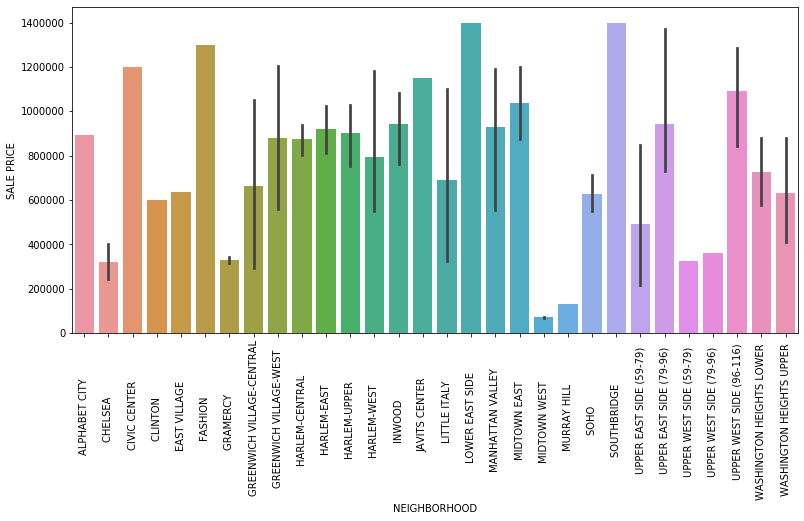

In [31]:
plt.figure(figsize=(13,6))

sns.barplot(x='NEIGHBORHOOD', y='SALE PRICE', data=df, )
plt.xticks(rotation=90)#Rotated to give the neighborhood axis more space

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

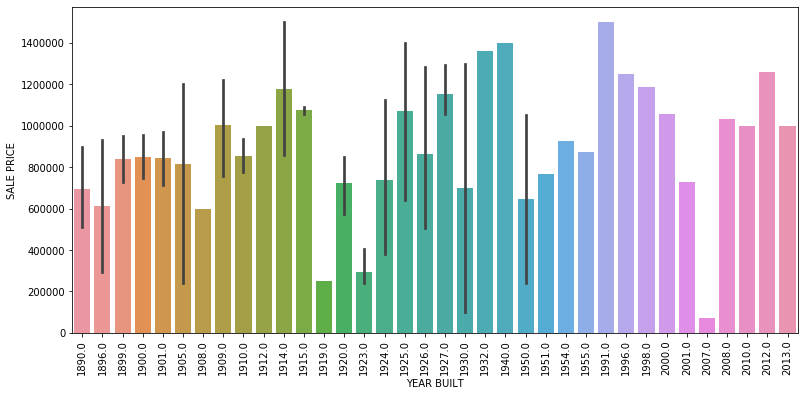

In [18]:
plt.figure(figsize=(13,6))
sns.barplot(x='YEAR BUILT', y='SALE PRICE', data=df)
plt.xticks(rotation=90)